In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pdb
import math
import random
%load_ext autoreload
%autoreload 2

# Toy example with variational inference
$x$ - input variable <br>
$z$ - hidden variable <br>
$y$ - output variable <br>
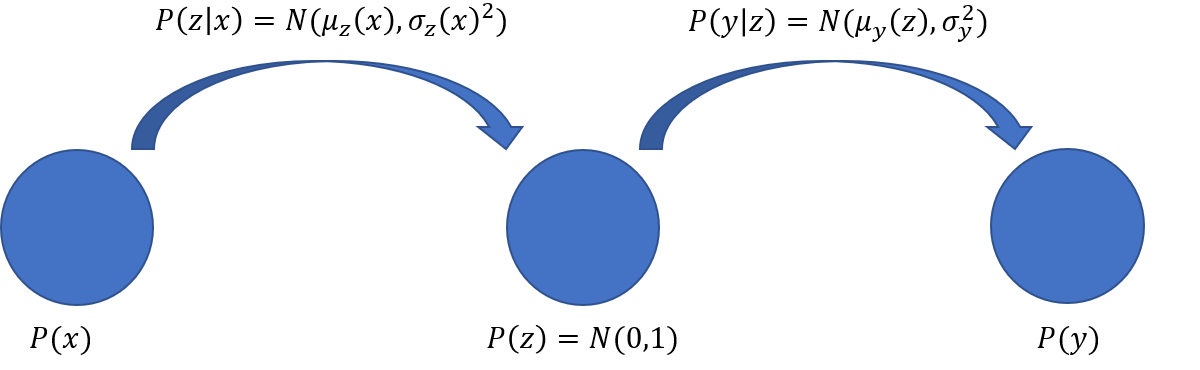

We want prior of hidden variable $P(z)$ to be described by probability density of standard normal: 
$$P(z)=\mathcal{N}(0,1) \text{ - "prior"}$$
There are two mappings of interest, which are also Gaussian: <br>
$$P(z|x)=\mathcal{N}(\mu_z(x),\sigma_z(x)^2) \text{ - "encoder"}$$
$$P(y|z)=\mathcal{N}(\mu_y(z),\sigma_y^2) \text{ - "decoder"}$$

Marginal probabilities of hidden and input variables are linked by law of total probability:
$$P(z) = \int P(z|x) P(x) dx$$

# Analytically tractable set of parameters
## Simplest setting
$$P(z) = \mathcal{N}(0,1) = \frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}z^2} $$
$$P(x) = \mathcal{N}(0,\sigma_x^2=\frac{1}{2}) = \frac{1}{\sqrt{\pi}}e^{-x^2}$$
$$P(z|x) = \mathcal{N}(\mu_z(x)=x,\sigma_z(x)^2=\frac{1}{2}) = \frac{1}{\sqrt{\pi}}e^{-(z-x)^2}$$
$$P(y|z) = \mathcal{N}(\mu_y(z)=z,\sigma_y^2=\frac{1}{2}) = \frac{1}{\sqrt{\pi}} e^{-(y-z)^2}$$
$$P(y|x) = \frac{1}{\sqrt{2\pi}}e^{-\frac{(x-y)^2}{2}}$$
$$P(y)   = \frac{1}{\sqrt{3\pi}}e^{-\frac{y^2}{3}} $$

$$P(x,z) = P(z|x)P(x)=\frac{1}{\pi}e^{-(z-x)^2-x^2}$$
$$P(y,z) = P(y|z)P(z)=\frac{1}{\pi \sqrt{2}}e^{-(y-z)^2-z^2/2}$$
$$P(y,x) = P(y|x)P(x)=\frac{1}{\pi \sqrt{2}}e^{-(x-y)^2/2-x^2}$$

Assume that
$$ P(y|x,z) = P(y|z) \text{ - Andrew's suggestion}$$
We will use:
$$ P(y|x) = \int P(y|x,z) P(z|x) dz $$
### Proof
$$P(y,x) = \int P(y,x,z) dz \text{ - Definition of marginal probability}$$
$$P(y,x) = P(y|x)P(x) \text{ - Chain rule with 2 events}$$
$$P(y,x,z)=P(y|x,z)P(x,z)=P(y|x,z)P(z|x)P(x) \text{ - Chain rule with 3 events}$$
Substituting equations 2 and 3 into 1 and dividing by $P(x)$, we get initial formula.
### Alternative proof
$$P(y) = \int P(y|z) P(z) dz \text{ - Law of total probability}$$
This equality can be conditioned on any additional event, including $x$.

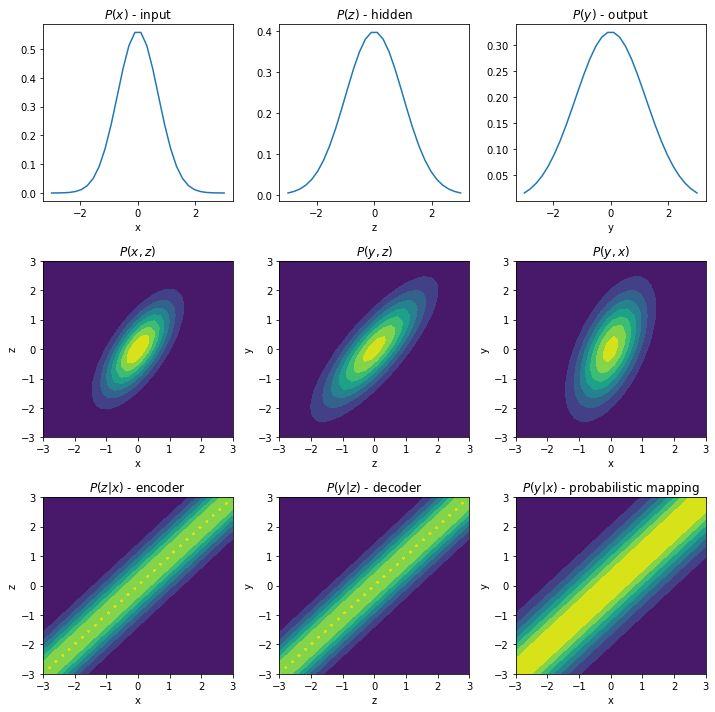

In [2]:
def normal(x,mu,sigma):
    return 1/(np.sqrt(2*np.pi)*sigma)* \
    np.exp(-1/2*(x-mu)**2/sigma**2)
def plot_analytic():
    fig = plt.figure(figsize=(10,10))
    plt.subplot(331)
    x = np.linspace(-3,3,30)
    pdf_x=normal(x,0,np.sqrt(1/2))
    plt.plot(x,pdf_x)
    plt.xlabel('x')
    plt.title(r'$P(x)$ - input')
    plt.subplot(332)
    z = np.linspace(-3,3,30)
    pdf_z=normal(z,0,1)
    plt.plot(z,pdf_z)
    plt.title(r'$P(z)$ - hidden')
    plt.xlabel('z')
    plt.subplot(333)
    y = np.linspace(-3,3,30)
    pdf_y=1/np.sqrt(3*np.pi)*np.exp(-y**2 / 3)
    plt.plot(y,pdf_y)
    plt.title(r'$P(y)$ - output')
    plt.xlabel('y')
    plt.subplot(337)
    [X,Z] = np.meshgrid(x,z)
    cpdf_z = 1/np.sqrt(np.pi) * np.exp(-(Z-X)**2)
    plt.contourf(X,Z,cpdf_z)
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title(r'$P(z|x)$ - encoder')
    plt.subplot(338)
    [Z,Y] = np.meshgrid(z,y)
    cpdf_y = 1/np.sqrt(np.pi) * np.exp(-(Y-Z)**2)
    plt.contourf(Z,Y,cpdf_y)
    plt.xlabel('z')
    plt.ylabel('y')
    plt.title(r'$P(y|z)$ - decoder')
    plt.subplot(339)
    [X,Y] = np.meshgrid(x,y)
    cpdf_y = 1/np.sqrt(2*np.pi) * np.exp(-(Y-X)**2/2)
    plt.contourf(X,Y,cpdf_y)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(r'$P(y|x)$ - probabilistic mapping')
    plt.subplot(334)
    [X,Z] = np.meshgrid(x,z)
    pdf = 1/np.pi * np.exp(-(Z-X)**2 - X**2)
    plt.contourf(X,Z,pdf)
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title(r'$P(x,z)$')
    plt.subplot(335)
    [Z,Y] = np.meshgrid(z,y)
    pdf = 1/(np.sqrt(2)*np.pi) * np.exp(-(Y-Z)**2 - 0.5*Z**2)
    plt.contourf(Z,Y,pdf)
    plt.xlabel('z')
    plt.ylabel('y')
    plt.title(r'$P(y,z)$')
    plt.subplot(336)
    [X,Y] = np.meshgrid(x,y)
    pdf = 1/(np.pi*np.sqrt(2)) * np.exp(-0.5*(Y-X)**2 - X**2)
    plt.contourf(X,Y,pdf)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(r'$P(y,x)$')
    plt.tight_layout()
    plt.show()
plot_analytic()

# Variational inference (VI)
Let we have pairs of data points 
$$(x_i, y_i)$$
and set prior for hidden variable $$P(z)=\mathcal{N}(0,1)$$
**Problem**:
Find probabilistic mappings <br> <center> $P(z|x)$ and $P(y|z)$. </center>
## Original VI formulation
**Note**:
Assumed that
$$x=y$$
Let we know decoder $P(x|z)$, which together with prior distribution $P(z)$ allows
to generate data from distribution $P(x)$.

**Variational inference is a method of approximate inverse of probabilistic mapping $P(x|z)$ to get hidden representation of the data $P(z|x)$** <br>
Inverse mapping is based on Bayes theorem. Resulting Loss involves encoder, decoder and prior $P(z)$.
This loss is used in VAE altogether, and optimization over both encoder and decoder is performed,
while prior serves as regularization.

## Approach: minimize Loss function without its derivation
Formal derivation of VI https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html cannot be repeated when $$x\neq y$$
and probabilistic encoder $P(z|x)$ and decoder $P(y|z)$ are no longer connected with Bayes theorem:
\begin{equation}
P(z|x) \neq P(y|z) \frac{P(z)}{P(x)}
\end{equation}
### Parametric representation
Define parametric approximations for encoder and decoder: <br>
<center> $P(z|x) \to q_{\phi}(z|x)$ and $P(y|z) \to q_{\theta}(y|z)$ </center>
Loss function on fixed pair of $(x_i,y_i)$:
$$L_{VAE}(\theta,\phi,x_i,y_i)= \underbrace{\text{Math expectation over } z}_{\text{z is distributed as } q_{\phi}(z|x_i)}
\left[ - \log q_{\theta}(y_i|z) \right] + D_{KL}(q_{\phi}(z|x_i), \mathcal{N}(0,1))$$

Specify explicit form of encoder and decoder with Neural networks:
$$q_{\phi}(z|x) =\mathcal{N}(g(x),h(x))$$
$$q_{\theta}(y|z)=\mathcal{N}(f(z),c)$$
where $h(x)$ and $c$ - variances.
Then Loss function:
$$L_{VAE}(x_i,y_i) = \frac{1}{2} \mathbb{E}_{z \sim \mathcal{N}(g(x_i),h(x_i))} \left[ \log c + \frac{(y_i - f(z))^2}{c} \right] + D_{KL}(\mathcal{N}(g(x_i),h(x_i)), \mathcal{N}(0,1))$$
Last approximation - change expectation with 1 Monte-Carlo sample (https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73):
$$L_{VAE}(x_i,y_i) = \frac{(y_i - f(z_i))^2}{2c} + \left[ - \frac{1}{2} \log h(x_i) + \frac{h(x_i) + (g(x_i))^2}{2} - \frac{1}{2} \right]$$
$$z_i = g(x_i) + \xi \sqrt{h(x_i)}, \xi \sim \mathcal{N}(0,1)$$

### KL divergence for Normal distribution
Derivation can be found here https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians
$$\mathcal{N}(\mu,\sigma^2) = \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$
$$ D_{KL}(p||q) = \int p(x) \log \frac{p(x)}{q(x)} dx $$
$$ D_{KL}(\mathcal{N}(\mu_1,\sigma^2_1), \mathcal{N}(\mu_2,\sigma^2_2)) = \log\frac{\sigma_2}{\sigma_1}+\frac{\sigma_1^2+(\mu_1-\mu_2)^2}{2\sigma_2^2}-\frac{1}{2}$$
Our regulartization looks as follows:
$$ D_{KL}(\mathcal{N}(g(x_i),h(x_i)), \mathcal{N}(0,1)) = - \frac{1}{2} \log h(x_i) + \frac{h(x_i) + (g(x_i))^2}{2} - \frac{1}{2}$$

# Learning with known variance of decoder $c=1/2$
Generally, $c$ is interpreted as free parameter https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73.

**Generating of dataset**

In [27]:
Npoints = 100000
sigma_x = np.sqrt(1/2)
sigma_z = np.sqrt(1/2)
sigma_y = np.sqrt(1/2)

# torch works with float32
x =     sigma_x * np.random.randn(Npoints).astype('float32')
z = x + sigma_z * np.random.randn(Npoints).astype('float32')
y = z + sigma_y * np.random.randn(Npoints).astype('float32')

# torch works with tensors N x 1
x_torch = torch.as_tensor(x).reshape((-1,1))
y_torch = torch.as_tensor(y).reshape((-1,1))

In [28]:
print(x_torch.dtype, x_torch.shape)
print(y_torch.dtype, y_torch.shape)

torch.float32 torch.Size([100000, 1])
torch.float32 torch.Size([100000, 1])


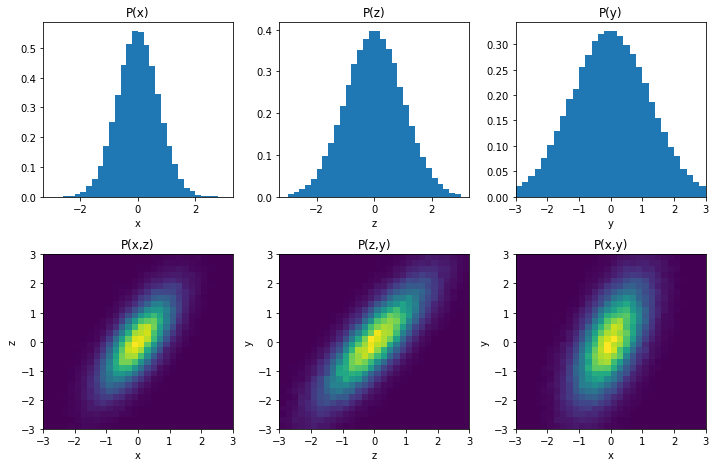

In [47]:
def plot_histograms(x, z, y, nbins=50, xy_range = 3):
    fig = plt.figure(figsize=(10,6.6))
    plt.subplot(231)
    plt.hist(x, bins=nbins, density = True, range=(-xy_range,xy_range));
    plt.xlabel('x')
    plt.title('P(x)')
    plt.subplot(232)
    plt.hist(z, bins=nbins, density = True, range=(-xy_range,xy_range));
    plt.xlabel('z')
    plt.title('P(z)')
    plt.subplot(233)
    plt.hist(y, bins=nbins, density = True, range=(-xy_range,xy_range));
    plt.xlabel('y')
    plt.title('P(y)')
    plt.xlim((-3,3))
    plt.subplot(234)
    counts, xbins, ybins = np.histogram2d(x, z, bins=(nbins, nbins), density=True, range=((-xy_range,xy_range),(-xy_range,xy_range)))
    counts = counts.T
    plt.pcolormesh(xbins, ybins, counts)
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title('P(x,z)')
    plt.subplot(235)
    counts, xbins, ybins = np.histogram2d(z, y, bins=(nbins, nbins), density=True, range=((-xy_range,xy_range),(-xy_range,xy_range)))
    counts = counts.T
    plt.pcolormesh(xbins, ybins, counts)
    plt.xlabel('z')
    plt.ylabel('y')
    plt.title('P(z,y)')
    plt.subplot(236)
    counts, xbins, ybins = np.histogram2d(x, y, bins=(nbins, nbins), density=True, range=((-xy_range,xy_range),(-xy_range,xy_range)))
    counts = counts.T
    plt.pcolormesh(xbins, ybins, counts)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('P(x,y)')
    plt.tight_layout()

plot_histograms(x,z,y,30)

**Comparison to analytical distributions**

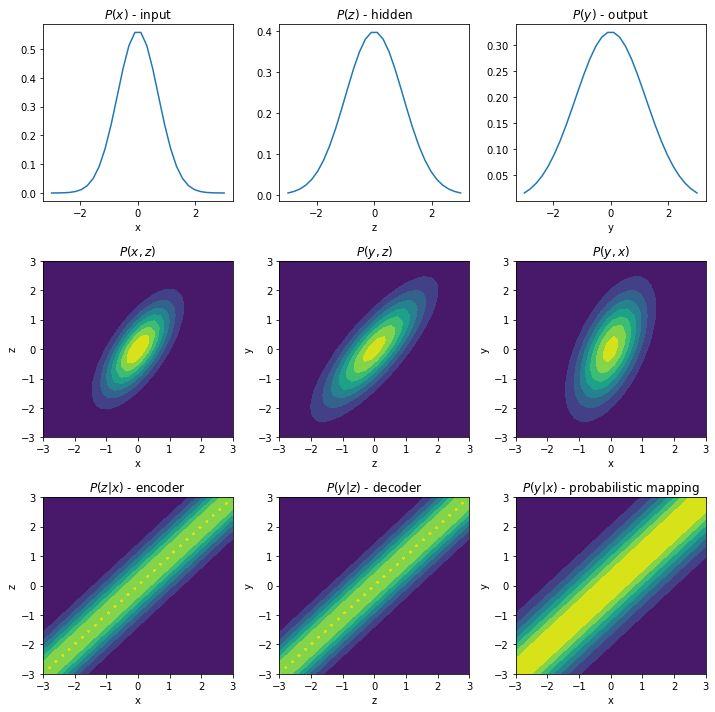

In [8]:
plot_analytic()

In [30]:
class Net(nn.Module):
    def __init__(self, width, depth):
        super().__init__()
        
        encoder_blocks = []
        encoder_blocks.extend([nn.Linear(1,width), nn.ReLU()])
        for j in range(depth-2):
            encoder_blocks.extend([nn.Linear(width,width), nn.ReLU()])
        encoder_blocks.append(nn.Linear(width,2))
        
        self.encoder = nn.Sequential(*encoder_blocks)
        
        decoder_blocks = []
        decoder_blocks.extend([nn.Linear(1,width), nn.ReLU()])
        for j in range(depth-2):
            decoder_blocks.extend([nn.Linear(width,width), nn.ReLU()])
        decoder_blocks.append(nn.Linear(width,1))
        
        self.decoder = nn.Sequential(*decoder_blocks)
    
    def forward(self, x):
        z = self.encoder(x)
        
        mean_z = z[:,0:1]
        var_z = nn.functional.softplus(z[:,1:2])
        
        z_sample = mean_z + torch.sqrt(var_z) * torch.randn(var_z.shape)
        
        y = self.decoder(z_sample)
        return y, mean_z, var_z, z_sample
    
    def generate_data(self, N, sigma, c):
        with torch.no_grad():
            x = sigma * torch.randn(N,1)
            y, mean_z, var_z, z = self.forward(x)
            y += np.sqrt(c) * torch.randn(y.shape)
        
        return np.array(x.squeeze()), np.array(z.squeeze()), np.array(y.squeeze())
        

In [31]:
def minibatch(x, y, batch_size=64):
    idx = np.arange(x.shape[0])
    np.random.shuffle(idx)
    batches = x.shape[0] // batch_size
    if (batches * batch_size < x.shape[0]):
        batches += 1
    for batch in range(batches):
        idxx = idx[batch*batch_size:(batch+1)*batch_size]
        xx = x[idxx]
        yy = y[idxx]
        yield xx,yy

In [32]:
def criterion(yhat, ytrue, mean_z, var_z, c): 
    error_mse = torch.square(ytrue - yhat) / (2*c)
    error_KL = 0.5*((var_z + torch.square(mean_z)) - torch.log(var_z) - 1)
    error = error_mse + error_KL
    
    n = error.shape[0]
    with torch.no_grad():
        error_sum = error.mean().item() * n
        error_mse = error_mse.mean().item() * n
        error_KL  = error_KL.mean().item() * n
    
    return error.mean(), error_sum, error_mse, error_KL, n

In [33]:
def train(net, x, y, c = 1/2, lr=0.001, num_epochs=100, batch_size=64):
    optimizer = optim.Adam(net.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(num_epochs/2), int(num_epochs*3/4), int(num_epochs*7/8)], gamma=0.1)
    
    net.loss = {'VAE_loss': [], 'MSE_loss': [], 'KL_loss': []}
    
    for epoch in range(num_epochs):
        epoch_loss = 0.
        epoch_mse = 0.
        epoch_KL = 0. 
        epoch_n = 0
        for xx, yy in minibatch(x, y, batch_size):
            optimizer.zero_grad()
            yhat, mean_z, var_z, z_smaple = net.forward(xx)
            loss, error, error_mse, error_KL, n = criterion(yhat, yy, mean_z, var_z, c)
            loss.backward()
            optimizer.step()
            
            epoch_loss += error
            epoch_mse += error_mse
            epoch_KL += error_KL
            epoch_n += n
        net.loss['VAE_loss'].append(epoch_loss / epoch_n)
        net.loss['MSE_loss'].append(epoch_mse / epoch_n)
        net.loss['KL_loss'].append(epoch_KL / epoch_n)
        scheduler.step()
        
        if epoch%10 == 0:
            print(f"epoch = {epoch+1}, numpoints = {epoch_n}, VAE_loss = {epoch_loss / epoch_n}, MSE_loss = {epoch_mse / epoch_n}, KL_loss = {epoch_KL / epoch_n}")

In [35]:
net = Net(3,1)

In [63]:
train(net, x_torch, y_torch, c=0.5, batch_size = 1000, num_epochs=100)

epoch = 1, numpoints = 100000, VAE_loss = 1.78799565076828, MSE_loss = 1.1480131793022155, KL_loss = 0.6399824765324592
epoch = 11, numpoints = 100000, VAE_loss = 1.5107501184940337, MSE_loss = 1.4558109664916992, KL_loss = 0.05493915501981974
epoch = 21, numpoints = 100000, VAE_loss = 1.5096729850769044, MSE_loss = 1.4852348208427428, KL_loss = 0.024438178706914185
epoch = 31, numpoints = 100000, VAE_loss = 1.5070342063903808, MSE_loss = 1.4928805589675904, KL_loss = 0.014153648111969232
epoch = 41, numpoints = 100000, VAE_loss = 1.5072574770450593, MSE_loss = 1.4953042674064636, KL_loss = 0.0119532076921314
epoch = 51, numpoints = 100000, VAE_loss = 1.5082494854927062, MSE_loss = 1.5007297539710998, KL_loss = 0.007519743829034269
epoch = 61, numpoints = 100000, VAE_loss = 1.5068417847156526, MSE_loss = 1.5002170383930207, KL_loss = 0.0066247400920838116
epoch = 71, numpoints = 100000, VAE_loss = 1.5064631450176238, MSE_loss = 1.4998667669296264, KL_loss = 0.0065963715454563495
epoch 

In [65]:
x_gen, z_gen, y_gen = net.generate_data(Npoints, sigma_x, c=1/2)

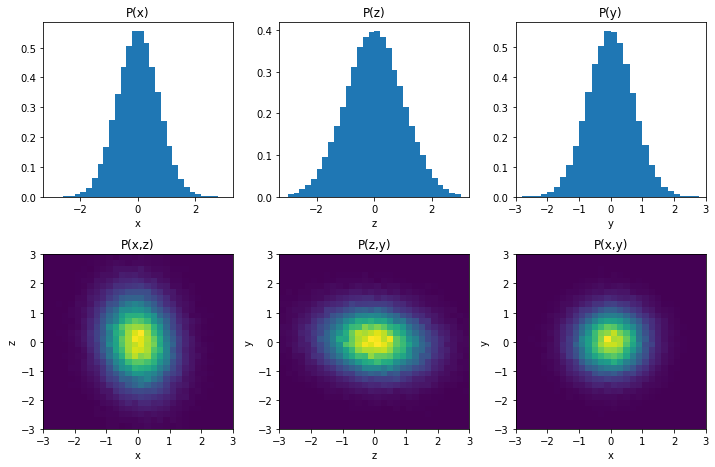

In [66]:
plot_histograms(x_gen,z_gen,y_gen,30,3)

### Reduce free parameter $c=0.1$

epoch = 1, numpoints = 100000, VAE_loss = 7.468068161010742, MSE_loss = 7.445850729942322, KL_loss = 0.022217383915558456
epoch = 11, numpoints = 100000, VAE_loss = 6.345310668945313, MSE_loss = 5.533665070533752, KL_loss = 0.8116454827785492
epoch = 21, numpoints = 100000, VAE_loss = 6.316072988510132, MSE_loss = 5.506662011146545, KL_loss = 0.8094109749794006
epoch = 31, numpoints = 100000, VAE_loss = 6.330217027664185, MSE_loss = 5.521663050651551, KL_loss = 0.8085538989305496
epoch = 41, numpoints = 100000, VAE_loss = 6.34340850353241, MSE_loss = 5.524779372215271, KL_loss = 0.8186290019750595
epoch = 51, numpoints = 100000, VAE_loss = 6.3306538152694705, MSE_loss = 5.5170084714889525, KL_loss = 0.8136453473567963
epoch = 61, numpoints = 100000, VAE_loss = 6.3342392539978025, MSE_loss = 5.524040007591248, KL_loss = 0.8101992702484131
epoch = 71, numpoints = 100000, VAE_loss = 6.30535050868988, MSE_loss = 5.494403820037842, KL_loss = 0.8109466660022736
epoch = 81, numpoints = 100000

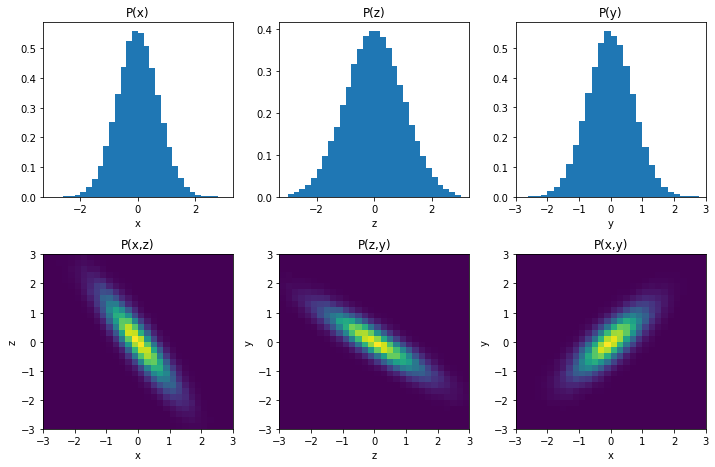

In [67]:
train(net, x_torch, y_torch, c=0.1, batch_size = 1000, num_epochs=100)
x_gen, z_gen, y_gen = net.generate_data(Npoints, sigma_x, c=0.1)
plot_histograms(x_gen,z_gen,y_gen,30,3)

### Free parameter c=0.2

epoch = 1, numpoints = 100000, VAE_loss = 3.519769904613495, MSE_loss = 2.858571000099182, KL_loss = 0.6611989337205887
epoch = 11, numpoints = 100000, VAE_loss = 3.4664054203033445, MSE_loss = 3.00275310754776, KL_loss = 0.46365234881639483
epoch = 21, numpoints = 100000, VAE_loss = 3.4622544264793396, MSE_loss = 2.9984457325935363, KL_loss = 0.46380871266126633
epoch = 31, numpoints = 100000, VAE_loss = 3.466433119773865, MSE_loss = 3.006223030090332, KL_loss = 0.4602100941538811
epoch = 41, numpoints = 100000, VAE_loss = 3.47589097738266, MSE_loss = 3.011416676044464, KL_loss = 0.4644743046164513
epoch = 51, numpoints = 100000, VAE_loss = 3.467659363746643, MSE_loss = 3.0048171520233153, KL_loss = 0.4628422424197197
epoch = 61, numpoints = 100000, VAE_loss = 3.473933546543121, MSE_loss = 3.007793345451355, KL_loss = 0.4661402177810669
epoch = 71, numpoints = 100000, VAE_loss = 3.4803358912467957, MSE_loss = 3.0161918020248413, KL_loss = 0.46414409577846527
epoch = 81, numpoints = 10

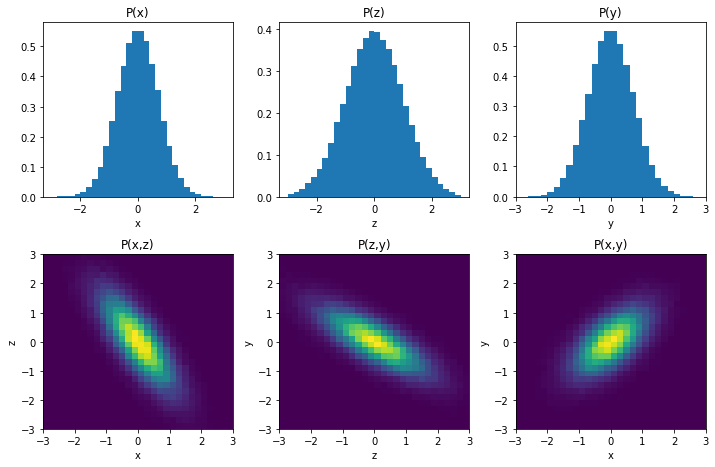

In [68]:
train(net, x_torch, y_torch, c=0.2, batch_size = 1000, num_epochs=100)
x_gen, z_gen, y_gen = net.generate_data(Npoints, sigma_x, c=0.2)
plot_histograms(x_gen,z_gen,y_gen,30,3)

### Free parameter $c=0.3$

epoch = 1, numpoints = 100000, VAE_loss = 2.4414640855789185, MSE_loss = 2.0782080698013305, KL_loss = 0.3632559686899185
epoch = 11, numpoints = 100000, VAE_loss = 2.4346153140068054, MSE_loss = 2.173562029600143, KL_loss = 0.2610532747209072
epoch = 21, numpoints = 100000, VAE_loss = 2.4355863976478576, MSE_loss = 2.174529265165329, KL_loss = 0.26105710208415983
epoch = 31, numpoints = 100000, VAE_loss = 2.4254096794128417, MSE_loss = 2.1628573679924012, KL_loss = 0.2625523369014263
epoch = 41, numpoints = 100000, VAE_loss = 2.436717336177826, MSE_loss = 2.174859827756882, KL_loss = 0.2618575119972229
epoch = 51, numpoints = 100000, VAE_loss = 2.4308683824539186, MSE_loss = 2.1706159889698027, KL_loss = 0.2602523975074291
epoch = 61, numpoints = 100000, VAE_loss = 2.4333981442451478, MSE_loss = 2.172395508289337, KL_loss = 0.26100267097353935
epoch = 71, numpoints = 100000, VAE_loss = 2.432305932044983, MSE_loss = 2.1715596222877505, KL_loss = 0.26074630916118624
epoch = 81, numpoint

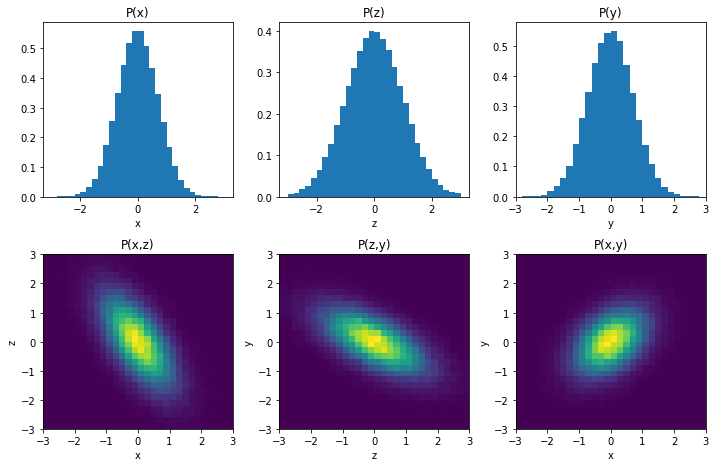

In [70]:
train(net, x_torch, y_torch, c=0.3, batch_size = 1000, num_epochs=100)
x_gen, z_gen, y_gen = net.generate_data(Npoints, sigma_x, c=0.3)
plot_histograms(x_gen,z_gen,y_gen,30,3)

### Free parameter $c=0.4$

epoch = 1, numpoints = 100000, VAE_loss = 1.8778286111354827, MSE_loss = 1.6789020824432372, KL_loss = 0.19892652973532676
epoch = 11, numpoints = 100000, VAE_loss = 1.8623436892032623, MSE_loss = 1.742241574525833, KL_loss = 0.12010213933885097
epoch = 21, numpoints = 100000, VAE_loss = 1.8659228670597077, MSE_loss = 1.7503356885910035, KL_loss = 0.11558718040585518
epoch = 31, numpoints = 100000, VAE_loss = 1.8685432112216949, MSE_loss = 1.7478109502792358, KL_loss = 0.12073224604129791
epoch = 41, numpoints = 100000, VAE_loss = 1.8669473731517792, MSE_loss = 1.7522617125511168, KL_loss = 0.1146856540441513
epoch = 51, numpoints = 100000, VAE_loss = 1.8693498873710632, MSE_loss = 1.752004350423813, KL_loss = 0.11734553433954716
epoch = 61, numpoints = 100000, VAE_loss = 1.8743520200252533, MSE_loss = 1.7576092708110809, KL_loss = 0.11674273371696473
epoch = 71, numpoints = 100000, VAE_loss = 1.8676876032352447, MSE_loss = 1.7508419287204742, KL_loss = 0.11684568747878074
epoch = 81, 

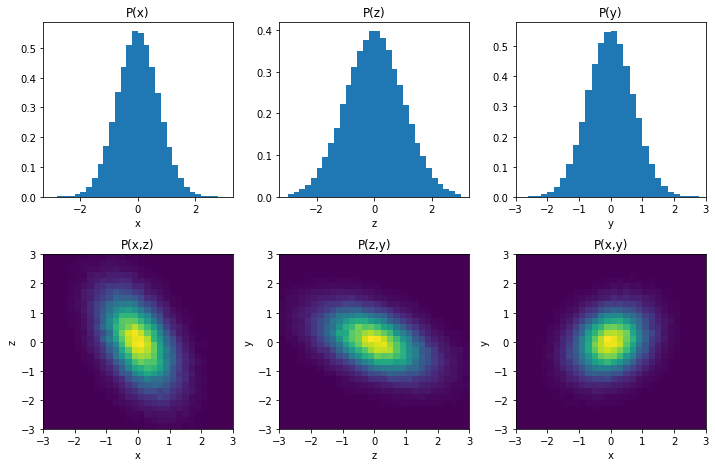

In [71]:
train(net, x_torch, y_torch, c=0.4, batch_size = 1000, num_epochs=100)
x_gen, z_gen, y_gen = net.generate_data(Npoints, sigma_x, c=0.4)
plot_histograms(x_gen,z_gen,y_gen,30,3)

# Optimality conditions
$$L_{VAE} = \int \frac{(y - f(g(x) + \xi \sqrt{h(x)}))^2}{2c} + \left[ - \frac{1}{2} \log h(x) + \frac{h(x) + (g(x))^2}{2} - \frac{1}{2} \right] \rho(x,y) \rho(\xi)dxdyd\xi$$
**Find optimum in class of functions**
$$g(x) = \alpha_g x \text{,         true value: } \alpha_g = 1$$
$$h(x) = \sigma^2_h \text{,         true value: } \sigma^2_h = \frac{1}{2}$$
$$f(z) = \alpha_z z \text{,         true value: } \alpha_z = 1$$
Then
$$L_{VAE} = \int \frac{(y - \alpha_z(\alpha_g x + \xi \sigma_h))^2}{2c} + \left[ - \log \sigma_h + \frac{\sigma_h^2 + \alpha_g^2 x^2}{2} - \frac{1}{2} \right] \rho(x,y) \rho(\xi)dxdyd\xi$$
$$\frac{\partial L_{VAE}}{\partial \alpha_g} = (\alpha_z^2+c)\alpha_g-\alpha_z=0$$
$$\frac{\partial L_{VAE}}{\partial \alpha_z} = (\alpha_g^2+2\sigma_h^2)\alpha_z-\alpha_g=0$$
$$\frac{\partial L_{VAE}}{\partial \sigma_h} = (\alpha_z^2+c)\sigma_h^2-c=0$$
**There are no true solutions for any $c$**
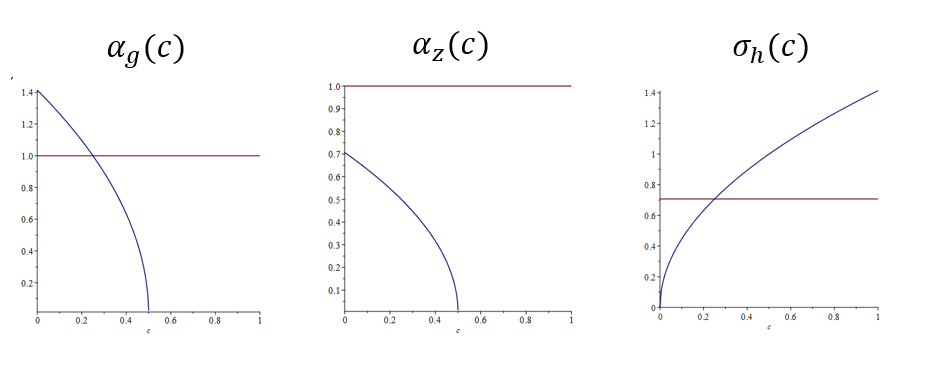

**May be this model can at least predict correct slope for $x-y$ regression?**

The true value for slope is recovered when $c=0$, i.e. Loss function is equal to MSE.
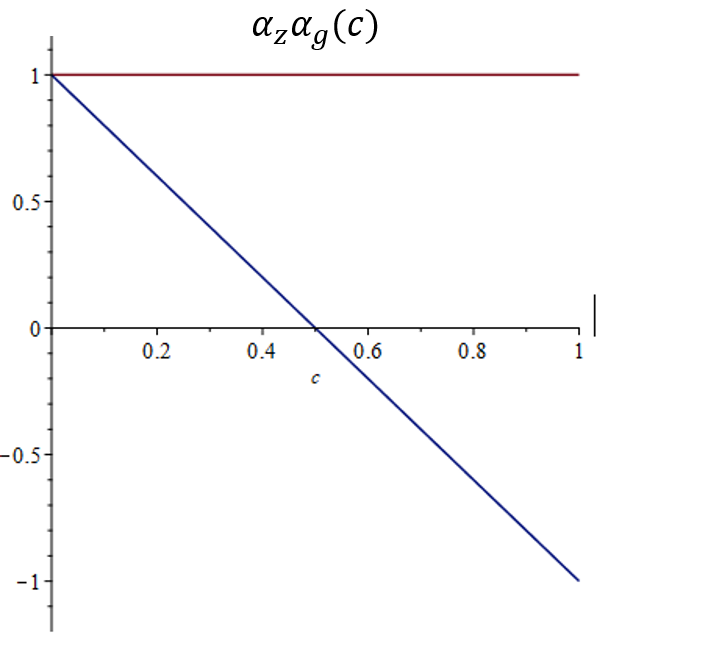